In [55]:
## Import libraries ##
import numpy as np
from scipy import stats
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import pandas as pd

In [56]:
## Define Basic functions ##

#generate points that aren't too close to each other
def generate_points(minX, maxX, N, min_distance = 0.05, dim = 1):
    points = []
    while len(points) < N:
        # Generate a random point
        point = np.random.uniform(-5, 5, size=(2,dim)) # Adjust range as needed
        if len(points) == 0:
            points.append(point)
        else:
            # Check distance with existing points
            valid_point = True
            for existing_point in points:
                distance = np.linalg.norm(point - existing_point)
                if distance < min_distance:
                    valid_point = False
                    break
            if valid_point:
                points.append(point)
    return np.concatenate(points)


# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()


#squared expo kernel
def kernel(a, b, kernelParameter_l, kernelParameter_sigma):
    #Hyperparameters:
    #kernelParameter_l = 1.94 #0.3 #1.94
    #kernelParameter_sigma = 1.75 #1.0 #1.75
    
    #Kernel:
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    sqexpo = (kernelParameter_sigma**2)*np.exp(-.5 * (1/(kernelParameter_l**2)) * sqdist)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return sqexpo


# Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
def posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
    '''
    
    N = len(X)
    n = 200 # number of test points X*
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + (sigma_n**2)*np.eye(N))

    ## 3) Predictive mean at test points
    Xtest = np.linspace(min(X), max(X), n).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diag mat since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    var = np.diag(sigma)
    std = np.sqrt(np.abs(var))
    
    return Xtest, mu, std


#Given test point x (Xtest_val), what is y?
def conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Given test point x (Xtest_val), what is y?
    '''
    N = len(X)
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + sigma_n**2*np.eye(N)) 

    ## 3) Predictive mean at test points
    Xtest = np.asarray([Xtest_val]).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diagonal matrix since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    var = np.diag(sigma)
    std = np.sqrt(np.abs(var))

    return Xtest_val, mu, std


#plot the posterior distribution of GPR
def plot_post(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    plot_post(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Plot the posterior distribution of GPR
    '''
    #Return mu and std:
    Xtest, mu, std = posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    print("Mean predictive std: ", np.mean(std))
    
    ## PLOT
    plt.clf()
    plt.figure(figsize=(8,4))

    # Plot training data
    plt.plot(X, y, 'k+', ms=18)
    # Plot test points
    #plt.plot(Xtest, f(Xtest), 'b-')
    # Plot predictive mean
    plt.plot(Xtest, mu, 'r--', lw=2)
    # Plot 2std above and below predictive mean
    plt.gca().fill_between(Xtest.flat, mu-2*std, mu+2*std, color="#dddddd")

    plt.title('Mean predictions +/- 2 std.')
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Y$')
    plt.show()

## Given

Plot of dataset and the function we'd like to estimate (our goal):

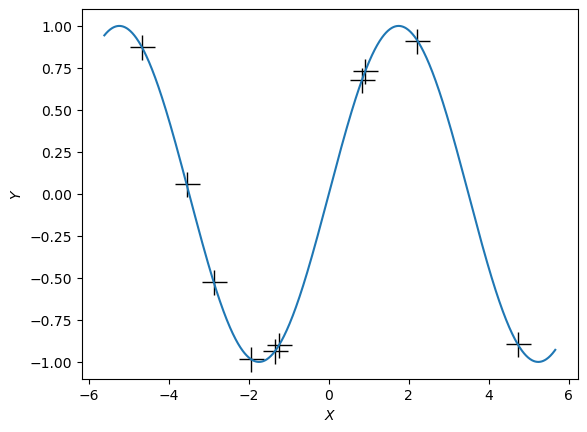

In [57]:
#This is our dataset:
N = 10 #must be even
X = generate_points(-5, 5, N/2, min_distance = 1, dim = 1)
y = (f(X) + np.random.normal(0,0,N)).reshape(-1,1) #observations (following true unknown function we wish to approx)

#Plot of data:
plt.plot(X, y, 'k+', ms=18)

#Function we'd like to estimate --> our goal
x = np.arange(min(X)-abs(min(X))*0.2, max(X)+abs(max(X))*0.2, 0.01).reshape(-1,1)
f_x = f(x)

#Render plots
plt.plot(x, f_x)
plt.axis([min(x)-abs(min(x))*0.1, max(x)+abs(max(x))*0.1, min(f(x))-abs(min(f(x)))*0.1,  max(f(x))+abs(max(f(x)))*0.1])
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

and we'll use this kernel in our GP:

We use the _Squared Exponential Kernel_, also called Radial Basis Function Kernel or Gaussian Kernel, as our covariance function:
\begin{equation}\label{eq:1}
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp\left(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)
\end{equation}
where the signal variance $\sigma_f^2$ (signal standard deviation $\sigma_f$) and the length scale $l$ are _hyperparameters_ which we'll want to optimize. In this example, this would result in a $n$x$n$ positive-definite covariance matrix $K$ where each element is $\kappa(x_i,x_j)$ with $x_i,x_j$ taken from the $n$ evenly spaced $x$ values for all $i,j\in \{1\ldots,n\}$.

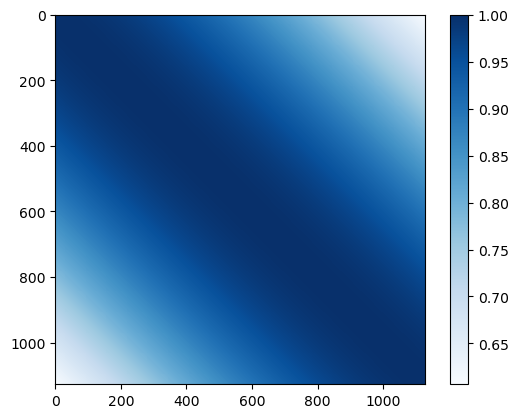

In [58]:
#Plot of kernel
x = x.reshape(-1,1)
x = (x - np.min(x))/(np.max(x) - np.min(x)) #X in [0,1]
K = kernel(x, x, 1, 1)

plt.imshow(K, cmap = 'Blues', interpolation = 'nearest')
plt.colorbar()
plt.show()

Normalize data:

In [59]:
#Normalize feature:
X = (X - np.min(X))/(np.max(X) - np.min(X)) #X in [0,1]

#Normalize target:
#y = (y - min(y))/(max(y)-min(y))

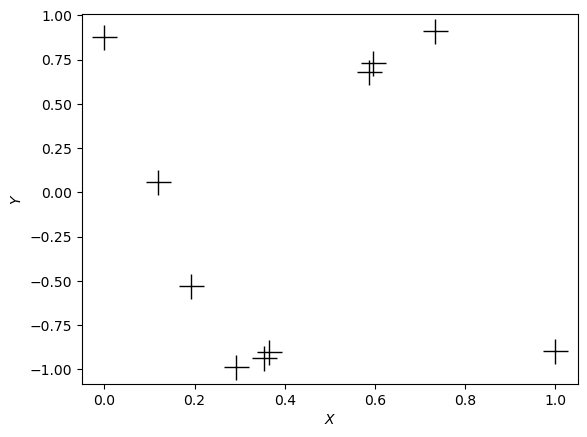

In [60]:
#Plot
plt.plot(X, y, 'k+', ms=18) #data points

plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

### 5.2 Method 1: Bayesian Model Selection

While there are many variations to model selection, most fall under one of three principles:

1) Find the probability of the model given the data. Ex: Bayesian model selection.

2) Estimate the generalization error. Ex: cross-validation.

3) Bound the generalization error.

The generalization error is the average error on test cases, following the same distribution as the training dataset. We do not aim for low training error since any model may fit the noise in the training set, leading to low training noise but high generalization error, which is an over-fit.

<br><br>
Sources used:
* Rasmussen and Williams, _Gaussian Process for Machine Learning_; pp. 108

The Bayesian view on model selection computes the probability of the model given the data via the marginal likelihood. We use a Bayesian treatment of the parameters as it views any uncertainties (like the parameters, hyperparameters, and models) as random variables with prior distributions.
- It's common practice to use **Bayesian hierarchical modelling**. This is where lowest level are the parameters $w$, like the coefficient parameters in a linear model or the weights in a neural network, the second level are the hyperparameters $\theta$ which determine the distribution of the parameters $w$, like the ''weight decay" term in a neural network or the $\lambda$ term in ridge regression, and the third level may be the set of models, like the choice of kernels.
<br><br>
Bayesian inference (levels 1 to 3):
1. Bayes' rule for the posterior over the parameters: 
$$
p(w\vert y, X, \theta, H_i) = \frac{p(y\vert X, w, H_i)p(w\vert \theta, H_i)}{p(y\vert X, \theta, H_i)}
$$
where $p(y\vert X, w, H_i)$ is the likelihood, $p(w\vert \theta, H_i)$ is the prior, and $p(y\vert X, \theta, H_i)$, which is independent of the parameters, is the marginal likelihood (which we've introduced before):
$$
p(y\vert X, \theta, H_i) = \int p(y\vert X, w, H_i)p(w\vert \theta, H_i) dw
$$
<br><br>
2. Bayes' rule for the posterior over the hyperparameters: here the marginal likelihood from 1. takes the role of the likelihood:
$$
p(\theta\vert y,X,H_i) = \frac{p(y\vert X,\theta,H_i)p(\theta\vert H_i)}{p(y\vert X,H_i)}
$$
where $p(\theta\vert H_i)$ is the hyper-prior (prior distribution for hyperparameters) and
$$
p(y\vert X, H_i) = \int p(y\vert X,\theta,H_i)p(\theta\vert H_i) d\theta
$$
3. Bayes' rule for the posterior over the models:
$$
p(H_i\vert y, X) = \frac{p(y\vert X, H_i)p(H_i)}{p(y\vert X)}
$$
where 
$$
p(y\vert X) = \sum_i p(y\vert X,H_i)p(H_i)
$$
<br><br>

The integrals above may or may not be analytically solvable, so in general we must resort other methods like Markov chain Monte Carlo (MCMC).

<br><br>
Sources used:
* Rasmussen and Williams, _Gaussian Process for Machine Learning_; pp. 109

**Exercise:** AME 565 Lab - Maximum Likelihood and Bayesian update

1) Generate $N$ sampes from a normal distribution with mean $1$ and standard deviation $2$. Using maximum likelihood estimation (MLE), find an estimate of the mean and standard deviation. Use an array of value estimates. Start with $N=5$ and increase gradually

2) Consider an exponential distribution of parameter $\lambda = 2$ that we want to estimate based on $N$ observations. First estimate $\lambda$ through MLE. Then use Bayesian update to find a distribution between $1$ and $3$ with standard deviation of $0.5$. In each case, find the maximum of the posterior using an array of $\lambda$ values.

3) Redo 1) and 2) but optimize the MLE

#### 1.

In [61]:
# Given:
N = 5
X = np.random.normal(1, 2, N)

We take $N$ samples $X_i\sim N(1,2^2)$. The pdf of $X_i$ is:
$$
f(x_i) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x_i-\mu)^2}{2\sigma^2}\right)
$$
We want to estimate the mean $\mu_0$ and variance $\sigma_0^2$ using the MLE.
<br>
The likelihood of these $N$ samples is
$$
L(\mu,\sigma^2\vert x_1,\ldots,x_N) = \prod_{i=1}^N f(x_i) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x_i-\mu)^2}{2\sigma^2}\right)
$$
$$
= (2\pi\sigma^2)^{-N/2}\exp\left(-\frac{1}{2\sigma^2}\sum_{i=1}^N(x_i-\mu)^2\right)
$$
Taking the log of $L$ gives us the log-likelihood:
$$
l(\mu,\sigma^2\vert x_1,\ldots,x_N) = -\frac{N}{2}\ln(2\pi) - \frac{N}{2}\ln(\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^N(x_i-\mu)^2
$$
We find the maximum likelihood estimators by solving the maximization problem $\max_{\mu,\sigma^2} l(\mu,\sigma^2,x_1,\ldots,x_N)$. Taking the partial derivative of the log-likelihood with respect to each parameter, setting each to $0$, and solving returns
$$
\hat{\mu_o} = \frac{1}{N}\sum_{i=1}^N x_i
$$
$$
\hat{\sigma_o^2} = \frac{1}{N}\sum_{i=1}^N(x_i - \hat{\mu_o})^2
$$
We use the last two results to estimate the mean and standard deviation of the given sample:

In [62]:
#N=5
mu_o = (1/N)*np.sum(X)
sigma_o = np.sqrt( (1/N)*np.sum((X-mu_o)**2) )
print(mu_o, sigma_o)

2.613989522788619 1.0642439993118822


In [63]:
#N=5,...,20
for N in range(5,21):
    X = np.random.normal(1, 2, N)
    mu_o = (1/N)*np.sum(X)
    sigma_o = np.sqrt( (1/N)*np.sum((X-mu_o)**2) )
    print("N=",N,"mu_0=",mu_o,"sigma_o=",sigma_o)

N= 5 mu_0= 2.361929137495277 sigma_o= 1.4752930831596938
N= 6 mu_0= 0.3220675970612242 sigma_o= 1.1961167817082834
N= 7 mu_0= 0.8309913525545491 sigma_o= 1.1078492554818757
N= 8 mu_0= 0.4811795381556116 sigma_o= 1.0740526343284553
N= 9 mu_0= 1.2582926288090581 sigma_o= 1.672494198767467
N= 10 mu_0= -0.05343861909940918 sigma_o= 1.5462813636446868
N= 11 mu_0= -0.20200734221221045 sigma_o= 2.387153586886162
N= 12 mu_0= 1.1695897924579501 sigma_o= 1.7885329805026988
N= 13 mu_0= 1.1589596805742435 sigma_o= 2.4002805699716645
N= 14 mu_0= 0.8320841095214091 sigma_o= 1.5011273202296989
N= 15 mu_0= -0.06160535332024569 sigma_o= 1.8895998852477272
N= 16 mu_0= 1.1284003217803384 sigma_o= 2.0875119056986886
N= 17 mu_0= 1.4330815088877973 sigma_o= 2.746605061817156
N= 18 mu_0= 1.2557413487872195 sigma_o= 2.2761614322922443
N= 19 mu_0= 1.3372517726745077 sigma_o= 1.3438006198316066
N= 20 mu_0= 0.985195244280273 sigma_o= 2.2469400459125843


In [64]:
N = 10000
X = np.random.normal(1, 2, N)
mu_o = (1/N)*np.sum(X)
sigma_o = np.sqrt( (1/N)*np.sum((X-mu_o)**2) )
print("N=",N,"mu_0=",mu_o,"sigma_o=",sigma_o)

N= 10000 mu_0= 1.0207552406769893 sigma_o= 1.9798606227234827


#### 2.

In [65]:
#Given:
N = 100
rate = 2 #lambda = 2
X = np.random.exponential(1/rate, N)

We take $N$ samples of $X_i\sim \text{Exp}(\lambda = 2)$. We want to estimate the rate parameter $\lambda_0$. The pdf of $X_i$ is
$$
f(x_i) = \lambda\exp(-\lambda x_i), x_i\in [0,\infty)
$$
The the likelihood is
$$
L(\lambda\vert x_1,\ldots,x_N) = \prod_{i=1}^N f(x_i) = \prod_{i=1}^N \lambda\exp(-\lambda x_i)
$$
$$
= \lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)
$$
Then the log-likelihood is
$$
l(\lambda\vert x_1,\ldots,x_N) = n\ln(\lambda) - \lambda\sum_{i=1}^N x_i
$$
Taking the partial derivative with respect to $\lambda$, setting it to $0$, and solving yields
$$
\hat{\lambda_o} = \frac{N}{\sum_{i=1}^N x_i}
$$
We use this result to estimate $\lambda_0$:

In [66]:
lambda_o = N/np.sum(X)
lambda_o

1.9264880262437978

We use a Bayesian update to find a distribution of $\lambda$ (posterior) via (a) uniform prior and (b) truncated normal with std of $0.5$.
<br>
a) The likelihood is a function of $\lambda$ with $X$ fixed was given above as
$$
p(X\vert \lambda) = \lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)
$$
The prior is $p(\lambda) = \frac{1}{2}, \lambda\in [1,3]$. 
<br>
Then the posterior probability is the probability of $\lambda$ given the $X$:
$$
p(\lambda\vert X) = \frac{p(X\vert\lambda)p(\lambda)}{\int p(X\vert\lambda)p(\lambda)d\lambda}
$$
$$
= \frac{\lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)}{\int_1^3 \lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)d\lambda}
$$

In [67]:
#a)
import scipy.integrate as integrate

def integrand1(lam): #denominator & numerator
    return lam**N * np.exp(-lam*np.sum(X))
denom1 = integrate.quad(integrand1, 1, 3)

def post1(lam): #this is the posterior
    return integrand1(lam)/denom1[0]

In [68]:
#double checking that our posterior integrates to 1
integrate.quad(post1,1,3)[0]

1.0000000000291918

In [69]:
#lets find the maximum of the posterior:
def obj_fun1(lam):
    return -1*post1(lam)

obj_list = []
lam_list = []
for lam in np.linspace(1,3,10):
    obj_list.append(obj_fun1(lam))
    lam_list.append(lam)

lam_list[np.argmin(obj_list)]

1.8888888888888888

b) The likelihood is a function of $\lambda$ with $X$ fixed was given above as
$$
p(X\vert \lambda) = \lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)
$$
The prior is $p(\lambda) = \text{Norm}(\lambda,0.5), \lambda\in [1,3]$. 
<br>
Then the posterior probability is the probability of $\lambda$ given the $X$:
$$
p(\lambda\vert X) = \frac{p(X\vert\lambda)p(\lambda)}{\int p(X\vert\lambda)p(\lambda)d\lambda}
$$
$$
= \frac{\lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)\text{Norm}(\lambda,0.5)}{\int_1^3 \lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)\text{Norm}(\lambda,0.5)d\lambda}
$$

In [70]:
#b)
import scipy.integrate as integrate

def integrand2(lam): #denominator & numerator
    return lam**N * np.exp(-lam*np.sum(X)) * stats.norm.pdf(lam,2,0.5) 
denom2 = integrate.quad(integrand2, 1, 3) #denominator

def post2(lam): #this is the posterior
    return integrand2(lam)/denom2[0]

In [71]:
#double checking that our posterior integrates to 1
integrate.quad(post2,1,3)[0]

1.000000001863422

In [72]:
#lets find the maximum of the posterior:
def obj_fun2(lam):
    return -1*post2(lam)

obj_list = []
lam_list = []
for lam in np.linspace(1,3,10):
    obj_list.append(obj_fun2(lam))
    lam_list.append(lam)

lam_list[np.argmin(obj_list)]

1.8888888888888888

#### 3.

In [73]:
#2)
#a)
min_a = minimize(obj_fun1, 1.1, method = "Nelder-Mead")
print(min_a)
min_b = minimize(obj_fun2, 1.1, method = "Nelder-Mead")
print(min_b)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -2.0691041376907764
             x: [ 1.927e+00]
           nit: 17
          nfev: 34
 final_simplex: (array([[ 1.927e+00],
                       [ 1.926e+00]]), array([-2.069e+00, -2.069e+00]))
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -2.2101178330978635
             x: [ 1.936e+00]
           nit: 17
          nfev: 34
 final_simplex: (array([[ 1.936e+00],
                       [ 1.936e+00]]), array([-2.210e+00, -2.210e+00]))
